In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
cd drive/MyDrive/SIAP/dataset/clean

[Errno 2] No such file or directory: 'drive/MyDrive/SIAP/dataset/clean'
/content/drive/MyDrive/SIAP/dataset/clean


In [95]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from tensorflow.keras.optimizers import Adam

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 15889 
# MAX_VOCAB_SIZE = 10000
# EMBEDDING_DIM = 100
EMBEDDING_DIM = 300

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

In [96]:
train = pd.read_csv('train_clean_removed_emoticons.csv')
sentences = train["Review Text"].fillna("DUMMY_VALUE").values
possible_labels = list(set(train["Rating"]))
y = train["Rating"].values
targets = to_categorical(y)

In [97]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4 steming kad ubacimo daje losije rezultate
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train['Cleaned_Review_Text'] = train['Review Text'].apply(clean_text)

In [99]:
new_str = [str(x) for x in train['Cleaned_Review_Text']]

df = pd.DataFrame(new_str)
temp = []
for i in range(len(df)):
  temp.append(preprocessing(df.iloc[i]))

In [100]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(temp)
sequences = tokenizer.texts_to_sequences(temp)
s = sorted(len(s) for s in sequences)
word2idx = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#print("Shape of data tensor:", data.shape)

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

# Loading pretrained embeding (Globe.6B.300d Stanford)

In [101]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [102]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [103]:
# embedding_layer = Embedding(
#     num_words,
#     EMBEDDING_DIM,
#     input_length=MAX_SEQUENCE_LENGTH,
# )

# embedding_layer = Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)
embedding_layer = Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [104]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# --------------------------------------
x = Conv1D(256, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(possible_labels) + 1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

In [105]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/5
128/128 [==============================] - 2s 13ms/step - loss: 1.2778 - accuracy: 0.5475 - val_loss: 1.0301 - val_accuracy: 0.5911
Epoch 2/5
128/128 [==============================] - 1s 10ms/step - loss: 0.9984 - accuracy: 0.5852 - val_loss: 0.9779 - val_accuracy: 0.6104
Epoch 3/5
128/128 [==============================] - 1s 10ms/step - loss: 0.9204 - accuracy: 0.6189 - val_loss: 0.9333 - val_accuracy: 0.6131
Epoch 4/5
128/128 [==============================] - 1s 10ms/step - loss: 0.8483 - accuracy: 0.6459 - val_loss: 0.9656 - val_accuracy: 0.6021
Epoch 5/5
128/128 [==============================] - 1s 10ms/step - loss: 0.7798 - accuracy: 0.6741 - val_loss: 0.9953 - val_accuracy: 0.6087


In [106]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [107]:
print(confusion_matrix(y, y_pred))

[[ 375  163   74   19   26]
 [ 304  489  285   84   75]
 [ 110  515  851  513  272]
 [  13   76  233 1652 1946]
 [   2   21   50  340 9625]]


In [108]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.57      0.51       657
           2       0.39      0.40      0.39      1237
           3       0.57      0.38      0.45      2261
           4       0.63      0.42      0.51      3920
           5       0.81      0.96      0.88     10038

    accuracy                           0.72     18113
   macro avg       0.57      0.54      0.55     18113
weighted avg       0.70      0.72      0.70     18113



In [109]:
print(f1_score(y, y_pred, average="micro"))

0.7172748854413957


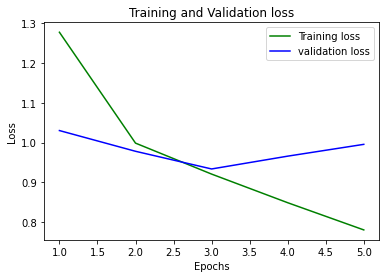

In [110]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
test = pd.read_csv('validation_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test = test["Rating"].values

In [112]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [113]:
print(confusion_matrix(y_test, y_pred))

[[  24   24   13    5   16]
 [  32   38   29   25   33]
 [  18   45   62   74   83]
 [   5   20   44  113  313]
 [   3   10   23   90 1120]]


In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.29      0.29      0.29        82
           2       0.28      0.24      0.26       157
           3       0.36      0.22      0.27       282
           4       0.37      0.23      0.28       495
           5       0.72      0.90      0.80      1246

    accuracy                           0.60      2262
   macro avg       0.40      0.38      0.38      2262
weighted avg       0.55      0.60      0.56      2262



In [115]:
print(f1_score(y_test, y_pred, average="micro"))

0.5999115826702034


In [116]:
model.save("cnn_model_0.599_glove.6b.300d_pretrained_embeding")

INFO:tensorflow:Assets written to: cnn_model_0.599_glove.6b.300d_pretrained_embeding/assets
